In [1]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# LOAD INPUT
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32')
x_train /= 255
x_train = x_train.reshape(x_train.shape[0],784)
x_train.shape, x_train.dtype

((60000, 784), dtype('float32'))

In [4]:
x_original = x_train

In [ ]:
x_train = x_train[y_train==2]

In [42]:
model = Sequential()
model.add(Dense(256,activation='tanh',input_dim=784))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='tanh'))
model.add(Dense(784,activation='sigmoid'))

model.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
             metrics = ['accuracy'])

model.fit(x_train,x_train,verbose=1,epochs=100,batch_size=256)

Epoch 1/100
5958/5958 [==============================] - 1s 110us/step - loss: 0.1872 - acc: 0.0040
Epoch 2/100
5958/5958 [==============================] - 0s 36us/step - loss: 0.1157 - acc: 0.0052
Epoch 3/100
5958/5958 [==============================] - 0s 39us/step - loss: 0.0842 - acc: 0.0039
Epoch 4/100
5958/5958 [==============================] - 0s 38us/step - loss: 0.0726 - acc: 0.0027
Epoch 5/100
5958/5958 [==============================] - 0s 37us/step - loss: 0.0679 - acc: 0.0023
Epoch 6/100
5958/5958 [==============================] - 0s 35us/step - loss: 0.0654 - acc: 0.0018
Epoch 7/100
5958/5958 [==============================] - 0s 40us/step - loss: 0.0635 - acc: 0.0037
Epoch 8/100
5958/5958 [==============================] - 0s 43us/step - loss: 0.0615 - acc: 0.0039
Epoch 9/100
5958/5958 [==============================] - 0s 39us/step - loss: 0.0593 - acc: 0.0052
Epoch 10/100
5958/5958 [==============================] - 0s 37us/step - loss: 0.0571 - acc: 0.0045
Epoch 11

5958/5958 [==============================] - 0s 49us/step - loss: 0.0138 - acc: 0.0079
Epoch 84/100
5958/5958 [==============================] - 0s 51us/step - loss: 0.0136 - acc: 0.0092
Epoch 85/100
5958/5958 [==============================] - 0s 52us/step - loss: 0.0135 - acc: 0.0086
Epoch 86/100
5958/5958 [==============================] - 0s 51us/step - loss: 0.0134 - acc: 0.0086
Epoch 87/100
5958/5958 [==============================] - 0s 48us/step - loss: 0.0133 - acc: 0.0094
Epoch 88/100
5958/5958 [==============================] - 0s 49us/step - loss: 0.0132 - acc: 0.0099
Epoch 89/100
5958/5958 [==============================] - 0s 52us/step - loss: 0.0130 - acc: 0.0101
Epoch 90/100
5958/5958 [==============================] - 0s 55us/step - loss: 0.0129 - acc: 0.0101
Epoch 91/100
5958/5958 [==============================] - 0s 59us/step - loss: 0.0128 - acc: 0.0096
Epoch 92/100
5958/5958 [==============================] - 0s 52us/step - loss: 0.0127 - acc: 0.0107
Epoch 93/100


In [44]:
from sklearn.metrics import mean_squared_error

mses = []
numbers = (2, 8)

def compute_mses(nr):
    input1 = x_original[nr].reshape(28, 28)
    output1 = model.predict(input1.reshape(1, 784)).reshape(28, 28)
    temp.append(mean_squared_error(input1.reshape(784), output1.reshape(784)))

for number in numbers:
    temp = []
    for j, nr in enumerate(np.where(y_train==number)[0]):
        compute_mses(nr)
    print(number)
    print('loss:', np.sum(np.array(temp))/(j+1))
    mses.append(temp)

2
loss: 0.011937483639955601
8
loss: 0.029964516782654674


### Plot Distributions

/home/fabrizio/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


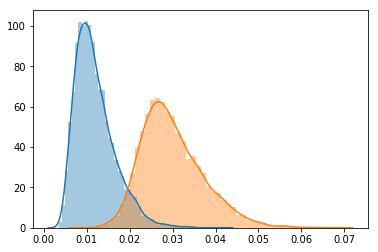

In [45]:
import seaborn as sns
sns.distplot(np.asarray(mses[0]))
sns.distplot(np.asarray(mses[1]))

### Performance Metrics

In [46]:
import ipywidgets as widgets

def outlyers(threshold=0.05):
    nr1 = len(np.where(np.array(mses[0])>threshold)[0])/len(mses[0])
    nr2 = len(np.where(np.array(mses[1])<threshold)[0])/len(mses[1])
    print('percentage of misclassified items:', (nr1 + nr2) / 2)

widgets.interact(outlyers, threshold=widgets.FloatSlider(min=0, max=0.2, step=0.001, value=0.05))

interactive(children=(FloatSlider(value=0.05, description='threshold', max=0.2, step=0.001), Output()), _dom_c…

<function __main__.outlyers(threshold=0.05)>

Performance table<br> 

1. K=1 --> 74%
2. K=2 --> 82%
3. K-3 --> 85%
4. K=4 --> 87%
...
10. K=10 --> 89%
...
64. K=64 --> 95%
...
128. K=128 --> 95%


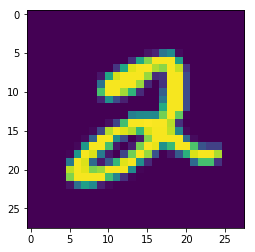

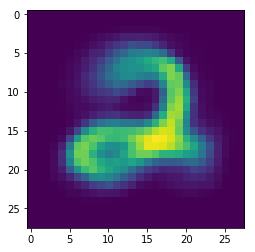

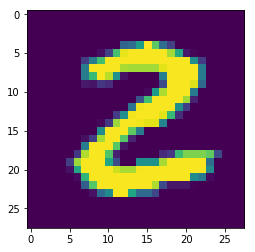

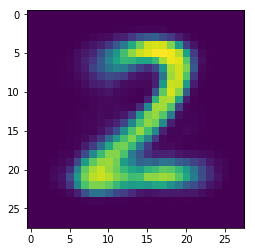

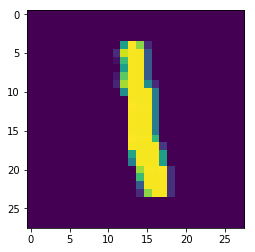

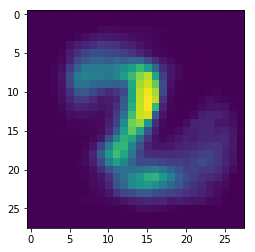

In [12]:
def plot(nr):
    input1 = x_original[nr].reshape(28, 28)
    output1 = model.predict(input1.reshape(1, 784)).reshape(28, 28)
 
    plt.imshow(input1)
    plt.show()
    plt.imshow(output1)
    plt.show()
plot(5)
plot(25)
plot(6)

In [47]:
def widget(x1=1, x2=1, x3=1, x4=1):
    get = K.function([model.layers[2].input], [model.layers[3].output])
    input2 = np.array([x1, x2, x3, x4]).reshape(1, 4)
    output = get([input2])
    plt.imshow(output[0].reshape(28, 28))

widgets.interact(widget, 
                 x1=widgets.FloatSlider(min=-1, max=20, step=0.01, value=10), 
                 x2=widgets.FloatSlider(min=-1, max=20, step=0.01, value=20),
                 x3=widgets.FloatSlider(min=-1, max=20, step=0.01, value=10), 
                 x4=widgets.FloatSlider(min=-1, max=20, step=0.01, value=8))
#layer_output = layer_output[0].tolist()
#layer_output = np.round(layer_output, decimals=1)       

interactive(children=(FloatSlider(value=10.0, description='x1', max=20.0, min=-1.0, step=0.01), FloatSlider(va…

<function __main__.widget(x1=1, x2=1, x3=1, x4=1)>

In [48]:
get = K.function([model.layers[0].input], [model.layers[1].output])
input3 = x_original[25].reshape(1, 784)
get([input3])[0]

array([[12.23551  ,  8.358166 ,  1.5685166, 17.46034  ]], dtype=float32)